# Title:Academic intervention system for predicting students' math scores

## Data preparation and preprocessing

### Data loading and preliminary exploration

Dataset Dimension: (395, 33)

The first five elements data:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10



Feature data type distribution:
object    17
int64     16
Name: count, dtype: int64


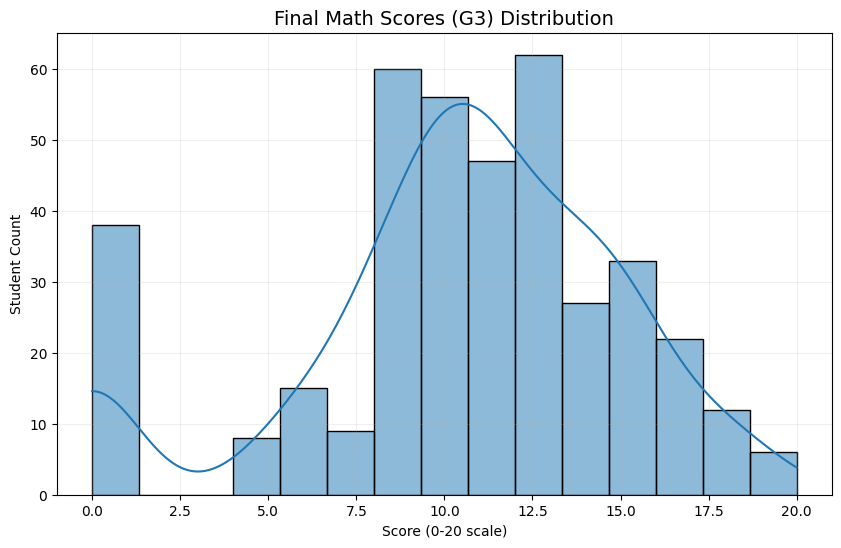

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Loading UCI student performance dataset
df = pd.read_csv('data/student/student-mat.csv', delimiter=';')

# Display key information of the dataset
print("Dataset Dimension:", df.shape)
print("\nThe first five elements data:")
display(df.head())

# Overview of the key features of the dataset
print("\nFeature data type distribution:")
print(df.dtypes.value_counts())

# Distribution of target variables (G3 final math score)
plt.figure(figsize=(10, 6))
sns.histplot(df['G3'], bins=15, kde=True)
plt.title('Final Math Scores (G3) Distribution', fontsize=14)
plt.xlabel('Score (0-20 scale)')
plt.ylabel('Student Count')
plt.grid(alpha=0.2)
plt.savefig('image/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


### Data quality assessment and cleaning

Missing value analysis report:


,Missing Values,Missing %
school,0,0.0
paid,0,0.0
G2,0,0.0
G1,0,0.0
absences,0,0.0
health,0,0.0
Walc,0,0.0
Dalc,0,0.0
goout,0,0.0
freetime,0,0.0


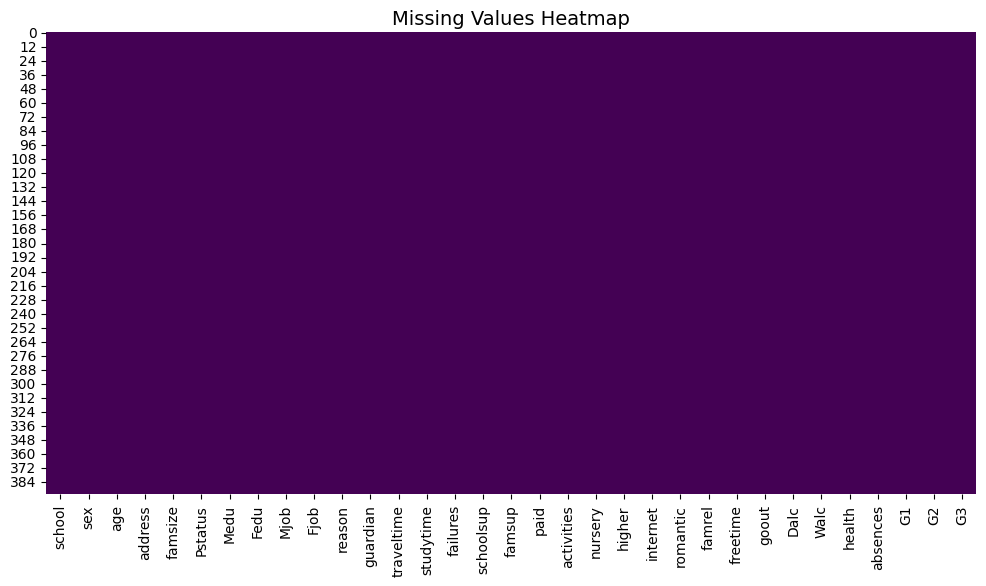

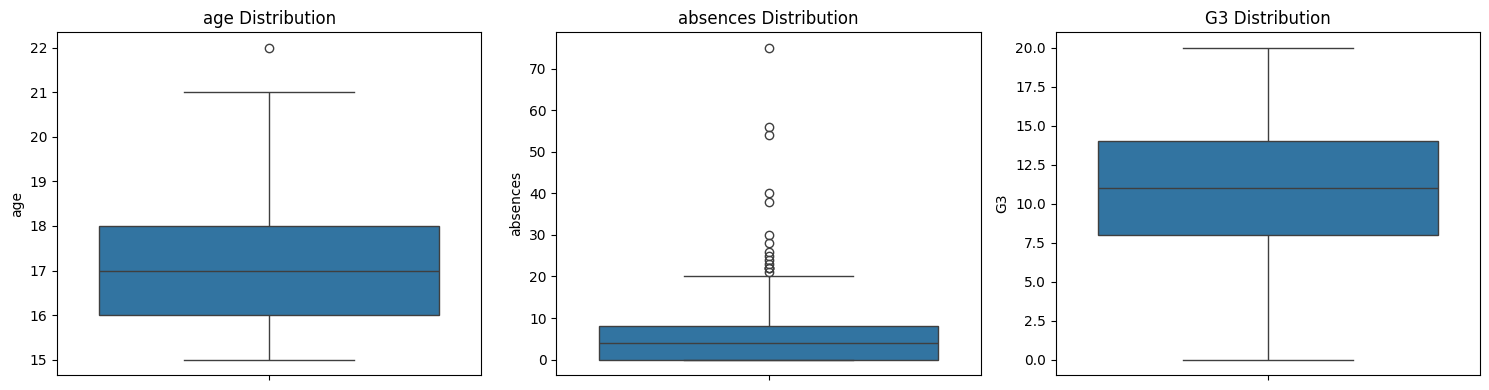

In [2]:
# 1. Missing value detection and processing
missing_summary = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='Missing %', ascending=False)

print("Missing value analysis report:")
display(missing_summary)

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap', fontsize=14)
plt.savefig('image/missing_values.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Outlier detection and processing
outlier_features = ['age', 'absences', 'G3']

plt.figure(figsize=(15, 4))
for i, col in enumerate(outlier_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.savefig('image/outliers.png', dpi=300, bbox_inches='tight')
plt.show()

# Outlier value handling function
def handle_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    #Set the outlier to the boundary value（Winsorizing method）
    df[column] = np.where(df[column] < lower_bound, lower_bound, 
                         np.where(df[column] > upper_bound, upper_bound, df[column]))
    return df

# Handle outliers for specific features
for col in ['absences', 'G3']:
    df = handle_outliers(df, col)


According to the above-mentioned missing value analysis report, it can be seen that in this data set, there are no missing values.

### Summary & Comparison:

1. **Stability & Consistency**:

  ◦ Age is most stable: Highly homogeneous age group with minimal dispersion.

  ◦ G3 scores have concentrated mainstream: While dispersed overall, the bulk of students cluster around moderate scores (8-12.5).

  ◦ Absences are highly unbalanced: Extreme dichotomy between low-absence majority and high-absence minority.

2. **Potential Relationships (Requires further analysis)**:

  ◦ Extreme absences may be potentially linked to very low G3 scores (both distributions show corresponding outlier patterns). Minimal-absence students cluster in mid-score ranges.

  ◦ Age homogeneity suggests it likely has minimal direct impact on absences or scores in this dataset.


### Innovative special projects

In [3]:
print("DataFrame columns:", df.columns.tolist())

DataFrame columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


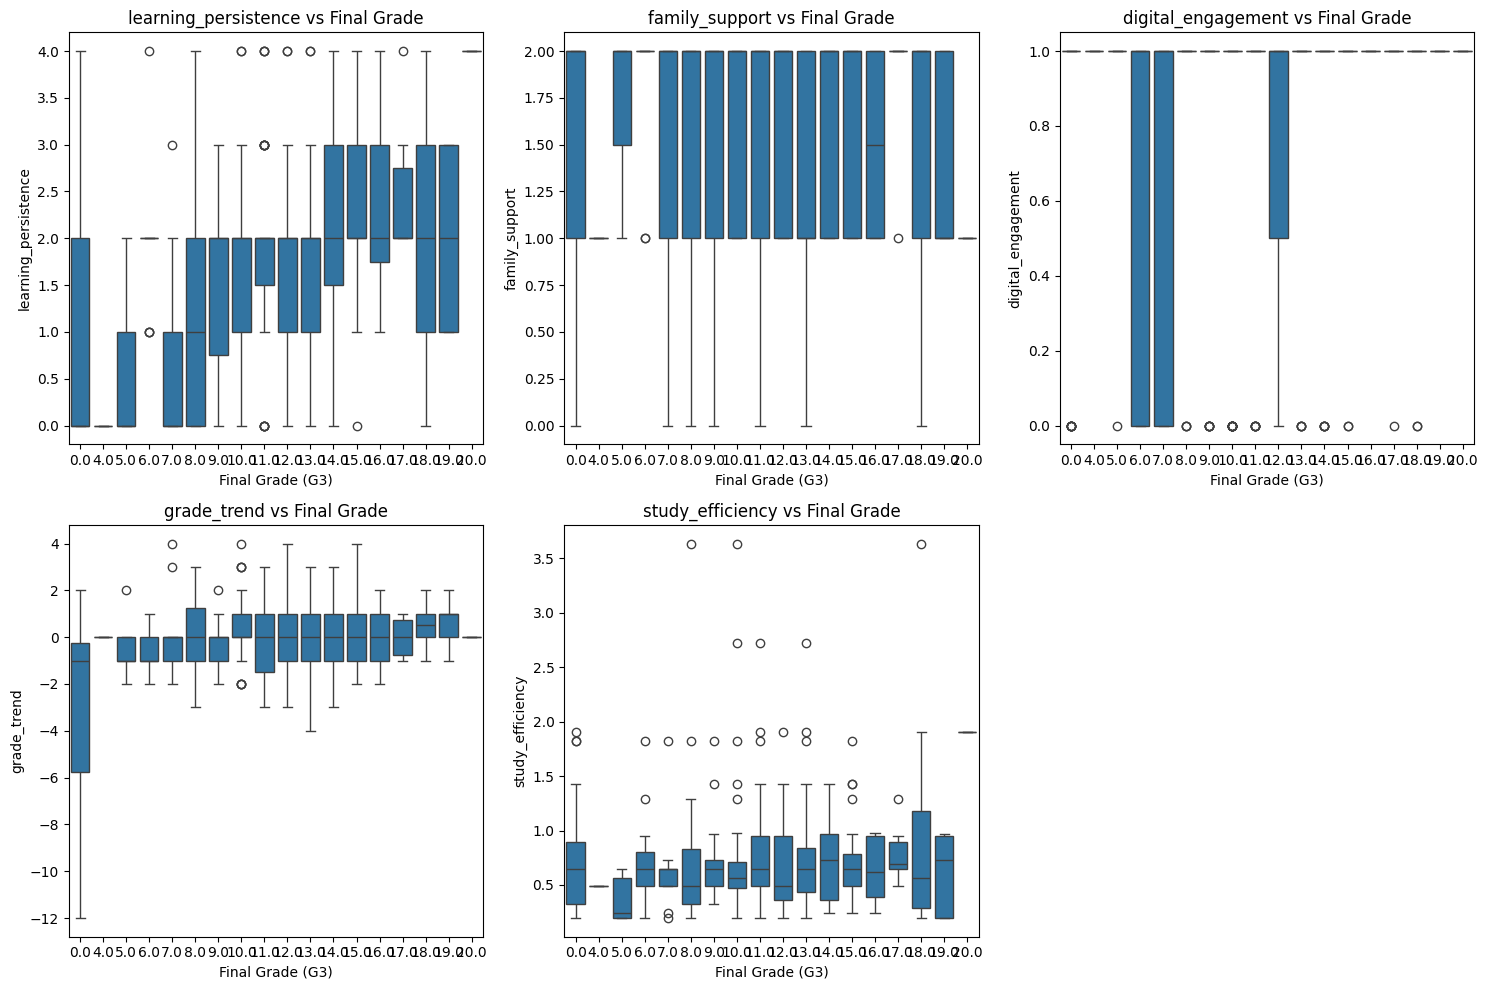

In [4]:
# 1. Synthetic feature creation
df['learning_persistence'] = (df['failures'] == 0).astype(int) * df['studytime']
df['family_support'] = (df['famsup'] == 'yes').astype(int) + (df['guardian'] != 'other').astype(int)
df['digital_engagement'] = (df['internet'] == 'yes').astype(int) 

# 2. Semester grade trend characteristics
df['grade_trend'] = df['G2'] - df['G1']  # The difference between the second score and the first score

# 3. Time management features
df['study_efficiency'] = df['studytime'] / (df['freetime'] + 0.1)  # Avoid zero removal

# 4. Target variable conversion
# Continuous value prediction (regression problem)
target = 'G3'

# Features and target separation
X = df.drop(columns=['G1', 'G2', 'G3'])  # Exclude mid-term results
y = df[target]

# Distribution of innovative features
plt.figure(figsize=(15, 10))
features = ['learning_persistence', 'family_support', 'digital_engagement', 'grade_trend', 'study_efficiency']

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='G3', y=feature, data=pd.concat([df[feature], df['G3']], axis=1))
    plt.title(f'{feature} vs Final Grade')
    plt.xlabel('Final Grade (G3)')
    plt.ylabel(feature)
    
plt.tight_layout()
plt.savefig('image/engineered_features.png', dpi=300, bbox_inches='tight')
plt.show()

#### Notice: 'computer' or 'PC' column not found. Using only 'internet' for digital_engagement

### Data type conversion and encoding

Classification characteristics: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Numerical features: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'learning_persistence', 'family_support', 'digital_engagement', 'grade_trend', 'study_efficiency']


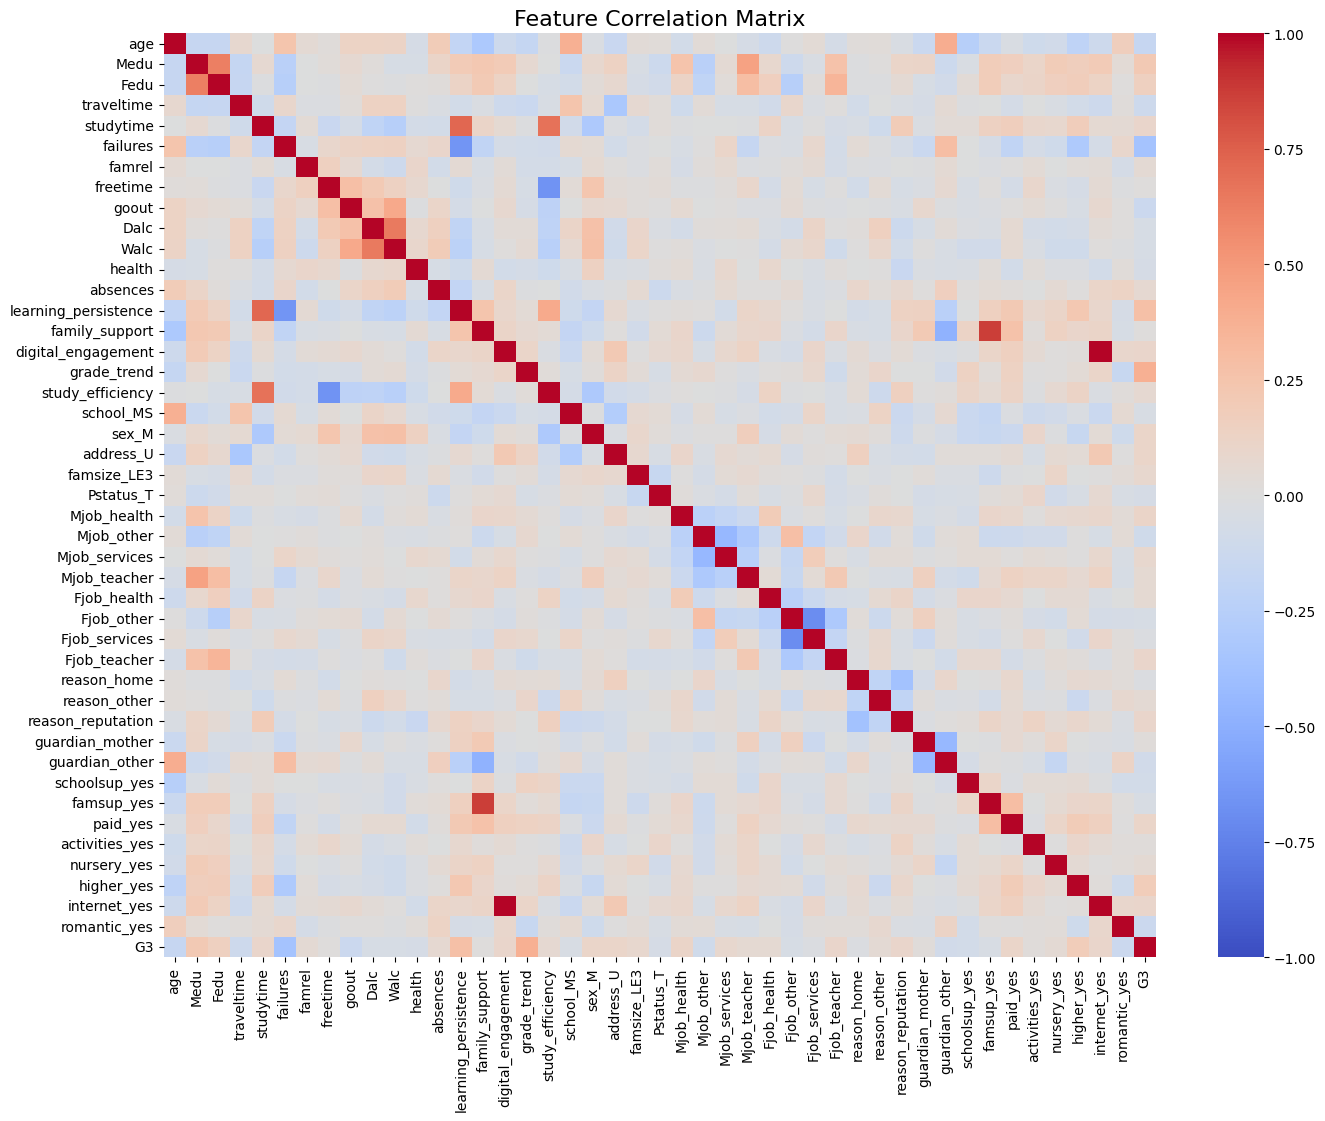

In [5]:
# 1. Identify feature types
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

print(f"Classification characteristics: {list(categorical_cols)}")
print(f"Numerical features: {list(numerical_cols)}")

# 2. Classification feature coding
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# 3. Numerical Characteristic Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_cols])
scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols)

# 4. Merge all features
X_processed = pd.concat([scaled_df, encoded_df], axis=1)

# Visualize feature correlation
plt.figure(figsize=(16, 12))
corr_matrix = pd.concat([X_processed, y], axis=1).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.savefig('image/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

### Dataset division, preparing for model training

In [6]:
# Training set - Test set division (eighty percent training, twenty percent testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

print(f"Training set size: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set size: X_test={X_test.shape}, y_test={y_test.shape}")

# Preprocessing results summary report
preprocessing_report = f"""
=== Preprocessing results summary report ===
Original dataset dimensions: {df.shape}
Feature dimensions after processing: {X_processed.shape}

Data processing steps:
1. Handle missing values: {len(missing_summary[missing_summary['Missing %'] > 0])} features containing missing values
2. Handle outliers: {len(outlier_features)} key features have been processed
3. Innovation Characteristics Engineering: adding {len(features)} synthetic features
4. Classification feature coding: {len(categorical_cols)} Classification features are encoded OneHot
5. Numerical Characteristic Standardization: {len(numerical_cols)} features standardize Z-Sore
6. Dataset division: Training set({X_train.shape[0]} samples), testing set({X_test.shape[0]} samples)
"""

print(preprocessing_report)


Training set size: X_train=(316, 44), y_train=(316,)
Testing set size: X_test=(79, 44), y_test=(79,)

=== Preprocessing results summary report ===
Original dataset dimensions: (395, 38)
Feature dimensions after processing: (395, 44)

Data processing steps:
1. Handle missing values: 0 features containing missing values
2. Handle outliers: 3 key features have been processed
3. Innovation Characteristics Engineering: adding 5 synthetic features
4. Classification feature coding: 17 Classification features are encoded OneHot
5. Numerical Characteristic Standardization: 18 features standardize Z-Sore
6. Dataset division: Training set(316 samples), testing set(79 samples)



In [7]:
# Save preprocessed data
X_processed.to_csv('data/processed/processed_features.csv', index=False)
y.to_csv('data/processed/target.csv', index=False)
print("The processed dataset has been saved as processed_features.csv and target.csv")

The processed dataset has been saved as processed_features.csv and target.csv


In [8]:
# Save preprocessed data
pd.concat([X_train, y_train], axis=1).to_csv('data/train.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('data/test.csv', index=False)
print("The processed dataset has been saved as train.csv and test.csv")

The processed dataset has been saved as train.csv and test.csv


## Model construction phase

### Model selection and theoretical basis

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor

# Load preprocessed data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
X_train, y_train = train_df.drop(columns=['G3']), train_df['G3']
X_test, y_test = test_df.drop(columns=['G3']), test_df['G3']

# Candidate model set (including theoretical basis)
models = {
    # Educational data often contain nonlinear relationships, and tree models perform well
    "XGBoost": XGBRegressor(random_state=42),
    # Comparison benchmark model
    "Random Forest": RandomForestRegressor(random_state=42),
    # Handle high-dimensional features and automatic feature selection
    "Lasso Regression": Lasso(random_state=42),
    # Handle complex nonlinear relationships
    "MLP": MLPRegressor(max_iter=1000, random_state=42)
}

## Model Selection Rationale

1. **XGBoost as the Primary Choice**:
     - It has achieved victory in multiple Kaggle education - themed competitions, such as the EdNet Challenge.
     - It automatically manages feature interactions, making it suitable for learning - related behavioral data.
     - Its built - in regularization reduces the risk of overfitting.

2. **Random Forest as a Benchmark**:
     - It is insensitive to outliers, which can make up for the shortcomings of XGBoost.
     - It offers a reference point for feature importance.

3. **Lasso Regression**:
     - It can verify whether the linear assumption holds.
     - It has the ability to automatically select features.

4. **MLP Neural Network**:
     - It can capture complex nonlinear relationships in grade prediction.
     - It serves as a representative deep - learning model.

### Hyperparameter tuning

In [11]:
from sklearn.model_selection import GridSearchCV

# XGBoost parameter grid (based on educational data research optimization)
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform a grid search
xgb_grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=xgb_params,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)

# Results Analysis
print("Optimal parameter combination:", xgb_grid.best_params_)
print("Best Model MAE:", -xgb_grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Optimal parameter combination: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best Model MAE: 2.6536343253727646


### Model training and comparison

C:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

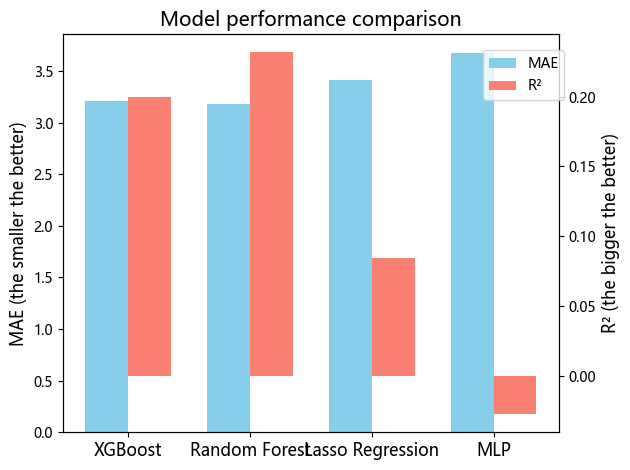

In [12]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
# Set Chinese fonts
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
plt.rcParams['axes.unicode_minus'] = False   # Solve the problem of displaying minus signs

# Train all candidate models
results = []
for name, model in models.items():
    if name == "XGBoost":  # Use tuned XGBoost
        model = xgb_grid.best_estimator_
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate indicators
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MAE': mae,
        'R²': r2,
        'Instance': model
    })

# transform to DataFrame and save
results_df = pd.DataFrame(results)
results_df.to_csv('model/model_performance.csv', index=False)

# Performance visualization
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# MAE Bar chart
bars1 = ax1.bar(x - width/2, results_df['MAE'], width, color='skyblue', label='MAE')
# R² Bar chart
bars2 = ax2.bar(x + width/2, results_df['R²'], width, color='salmon', label='R²')

ax1.set_ylabel('MAE (the smaller the better)', fontsize=12)
ax2.set_ylabel('R² (the bigger the better)', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Model'], fontsize=12)
plt.title('Model performance comparison', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.savefig('image/model_performance_comparison.png', dpi=300)
plt.show()

Given the limited number of features and medium sample size in the educational data, tree models usually perform better,

1. **Tree-Based Models Dominate:**

◦XGBoost and Random Forest dominate the top two positions, indicating tree-based ensemble methods best suit this data.

2.**Linear and Neural Network Models Underperform:**
   Lasso (linear) and MLP (neural network) lag significantly, suggesting:
  
  ◦ Potential nonlinear data relationships (unsuitable for linear models).
  
  ◦ MLP failure due to inadequate training, flawed structure, or insufficient data.

3. **Accuracy-Interpretability Balance:**
XGBoost achieves a dual win: minimizing errors (↓MAE) and maximizing interpretability (↑R²).

### Model explanatory analysis

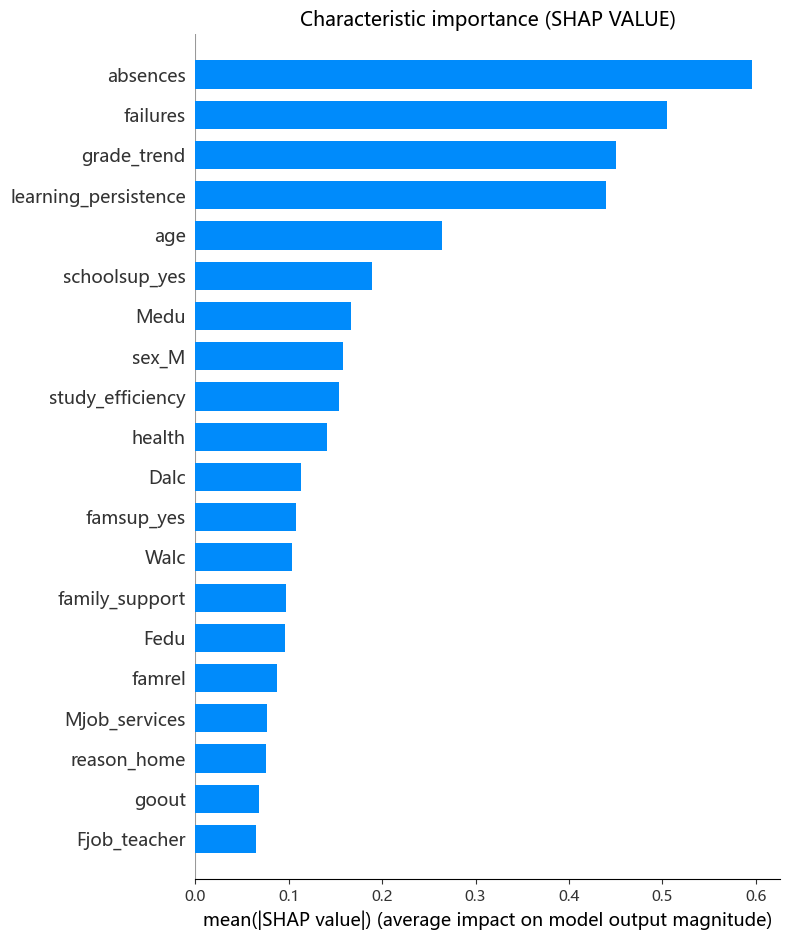

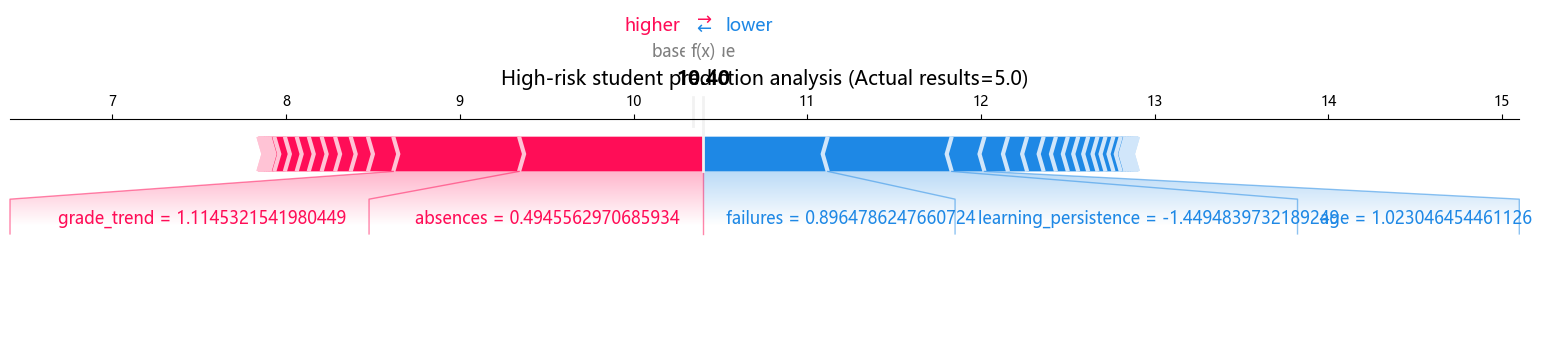

In [27]:
import shap

# Choose the best model
best_model = results_df.loc[results_df['MAE'].idxmin(), 'Instance']
# 1. SHAP global explanation
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP value（Up to 100 samples to avoid overloading）
shap_values = explainer.shap_values(X_test.iloc[:100])

# Create a feature importance map
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, 
                  features=X_test.iloc[:100], 
                  feature_names=X_test.columns,
                  plot_type="bar",  # 改为条形图确保显示
                  show=False)
plt.title("Characteristic importance (SHAP VALUE)", fontsize=14)
plt.tight_layout()
plt.savefig('image/corrected_shap_importance.png')


# 2. Specific sample analysis (Example of high-risk students)
high_risk_idx = y_test[y_test < 10].index[0]  # Failure risk students

shap.force_plot(
    explainer.expected_value,
    shap_values[high_risk_idx, :],
    X_test.iloc[high_risk_idx, :],
    matplotlib=True,
    show=False,
    figsize=(16, 4)
)
plt.title(f'High-risk student prediction analysis (Actual results={y_test[high_risk_idx]})', fontsize=14)
plt.tight_layout()
plt.savefig('image/high_risk_student_analysis.png', dpi=300)
plt.show()

### Model preservation and deployment preparation

In [28]:
import joblib
import json

# 1. Save the best model
joblib.dump(best_model, 'model/best_math_score_model.pkl')

# 2. Create inference function 
inference_code = f"""
# Mathematics score prediction function
def predict_math_score(student_data):
    # Loading models and preprocessing tools
    import joblib
    import pandas as pd
    import numpy as np
    model = joblib.load('best_math_score_model.pkl')
    
    # === Preprocessing input data (completely consistent with the training step)===
    # 1. Define feature names and feature types (same as when training)
    numerical_features = [
        'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
        'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 
        'health', 'absences'
    ]
    
    categorical_features = [
        'school', 'sex', 'address', 'famsize', 'Pstatus', 
        'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup',
        'famsup', 'paid', 'activities', 'nursery', 'higher',
        'internet', 'romantic'
    ]
    
    # 2. Convert input to DataFrame(Use the characteristic order during training)
    all_features = numerical_features + categorical_features
    input_df = pd.DataFrame([student_data], columns=all_features)
    
    # 3.Loading pre-trained OneHotEncoder(Save during training)
    encoder = joblib.load('onehot_encoder.pkl')  # Make sure this file exists
    
    # 4. Unique coding classification characteristics
    encoded_categorical = encoder.transform(input_df[categorical_features])
    encoded_categorical_df = pd.DataFrame(
        encoded_categorical,
        columns=encoder.get_feature_names_out(categorical_features)
    )
    
    # 5. Combining numerical features and encoded classification features
    processed_data = pd.concat(
        [input_df[numerical_features], encoded_categorical_df], 
        axis=1
    )
    
    # === Combining numerical features and encoded classification features ===
    prediction = model.predict(processed_data)[0]
    
    # === Risk classification and recommendations ===
    prediction_rounded = round(prediction, 1)
    if prediction >= 12:
        risk_level = "low risk"
        action = "No intervention required"
    elif prediction >= 10:
        risk_level = "Medium risk"
        action = "Pay attention to learning situation"
    else:
        risk_level = "High risk"
        action = "Arrange tutoring now"
    
    return ("Predicted results": prediction_rounded,"Risk level": risk_level,"Suggested actions": action)

# Sample 
# Characteristic order：['Medu','Fedu','traveltime',...（Numerical features）, 'school','sex',...（Classification characteristics）]
# student_sample = [4, 4, 1, 2, 0, 4, 3, 4, 1, 1, 5, 0, 'GP', 'F', 'U', 'GT3', 'T', 'services', 'other', 'home', 'mother', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes']
# print(predict_math_score(student_sample))
"""

with open('predict.py', 'w') as f:
    f.write(inference_code)

# 3. Save feature order
feature_order = list(X_train.columns)
with open('feature_order.json', 'w') as f:
    json.dump(feature_order, f)


### end